<a href="https://colab.research.google.com/github/komal83/phdthesis/blob/main/DTM_Pickle_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Stuff
!pip install spacy_udpipe
import nltk; nltk.download('stopwords')
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
import re
import bz2
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
import spacy_udpipe
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import ldaseqmodel
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
drive.mount('/content/drive', force_remount=True)


In [ ]:
#@title Extension declaration. change working directory to data directory
extension = 'bz2'
os.chdir("<>")

In [ ]:
#@title Yield Function to read data
def getData(start,end):
    #df_list = list()
    for d in pd.date_range(start,end):
        filename = d.strftime('40wita_%Y-%m-%d.csv.bz2')
        data = pd.read_csv(filename)
        yield(data)

In [ ]:
#@title Data Input
data=[]
id=[]
text=[]
#input_data =[]
data_input =[]
day=[]
for foo in getData('2020-02-01', '2020-04-30'):
        id.append(foo['id'])
        text.append(foo['text'])
        text=foo.text.values.tolist()
        day.append(foo['day'])
data_input=list(zip(id,text,day))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
#@title NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('italian')

In [ ]:
#@title url removal
# Convert to list
data = text
# Remove url
data = [re.sub(r"http\S+", "", sent) for sent in data]

In [ ]:
#@title def Tokenizer  and stop words removal function


    
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]



In [ ]:
#@title Pre tokenization with gensim
data_words = list(sent_to_words(data))

In [ ]:

#@title Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
#@title Def lemmatization Function
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp=spacy_udpipe.load_from_path(lang="it",
#                                   path="/content/drive/My Drive/COVID-19/italian-postwita-ud-2.5-191206.udpipe",
#                                   meta={"description": "Custom 'it' model"}, disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#@title Lemmatization with  Spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp=spacy_udpipe.load_from_path(lang="it",
                                  path="<italian-postwita-ud-2.5-191206.udpipe>",
                                  meta={"description": "Custom 'it' model"})

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# print(data_lemmatized)

In [ ]:
#@title  Create Dictionary, corpus, term frequency
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
#@title Model run LDASeq
#the following time slices refer to the whole dataset, slices into 7 days time slices.
time_slices=[2187,2017,21964,15870,27138,41889,36774,33609,26624,24134,22574,16310,21747]
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slices, num_topics=5)


In [ ]:
#@title pickle model id2word save
# your code
 pickle.dump(ldaseq,open('<dtm_pickle.pkl>','wb'))
#ldasqe_copy = pickle.load(file('<dtm_pickle.model>'))

 pickle.dump(id2word,open('<id2word.pkl>','wb'))


In [ ]:
#@title load pickle model 
with open('<dtm_pickle.pkl>' , 'rb') as pickle_file:
    ldaseq = pickle.load(pickle_file)

In [ ]:
#@title load pickle id2word 
with open('<id2word.pkl>', 'rb') as pickle_file:
    id2word_pickle = pickle.load(pickle_file)

In [ ]:
ldaseq.print_topic_times(topic=0)

In [ ]:
result = pd.concat(list(
    map(
        lambda t: pd.concat(list(map(
            lambda x: pd.DataFrame(x[1], columns=["token", "relevance"]).assign(topic=t, time=x[0]),
            enumerate(ldaseq.print_topic_times(topic=t))
        ))),
        range(0, 5)
    )
))

In [ ]:
print(result)

In [ ]:
# @title Save Result to external csv file

# result.to_csv("<result.csv>")

https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


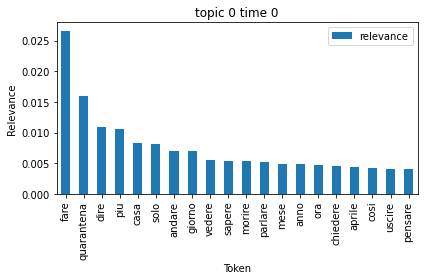

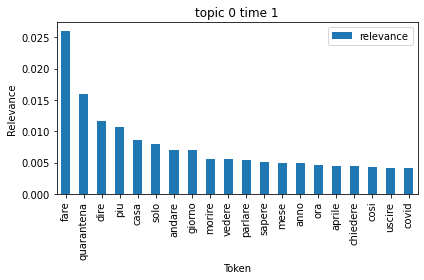

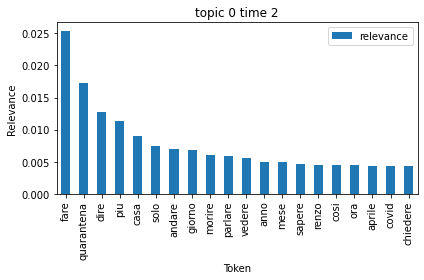

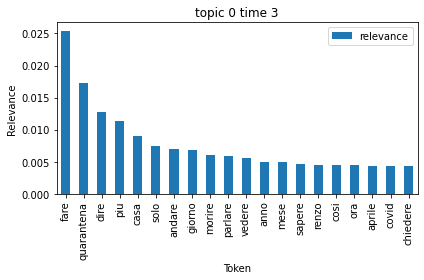

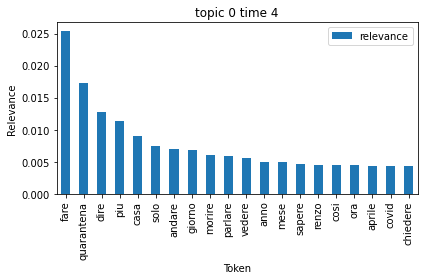

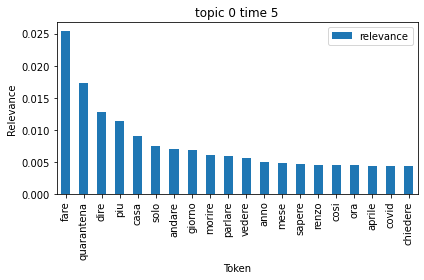

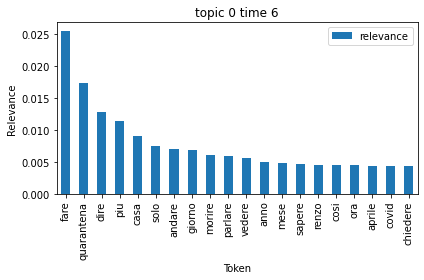

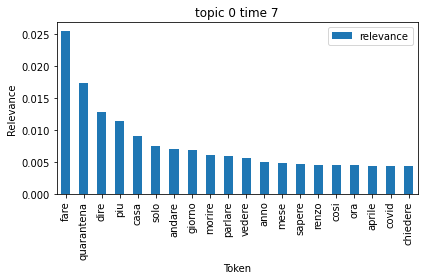

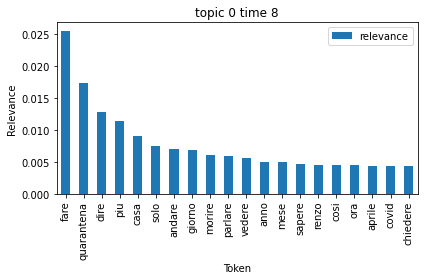

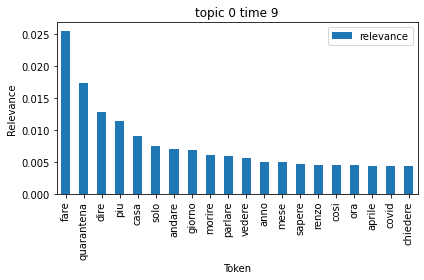

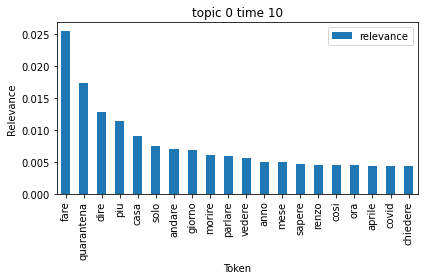

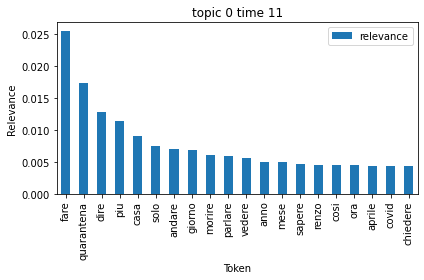

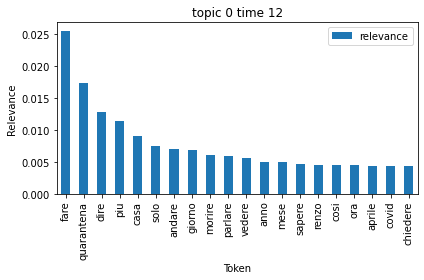

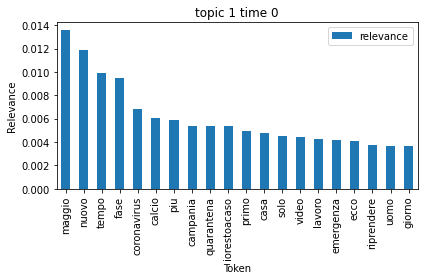

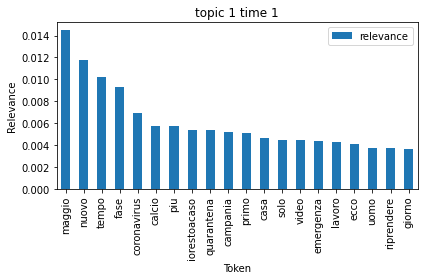

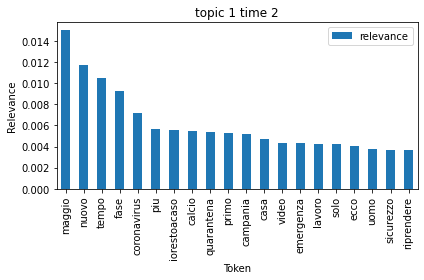

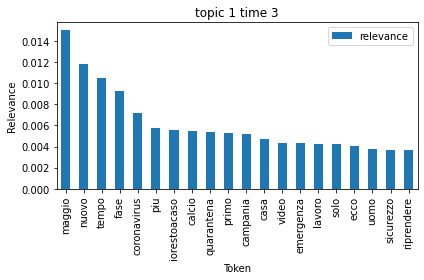

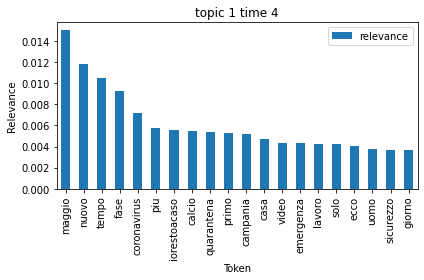

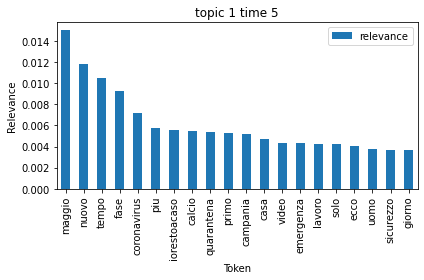

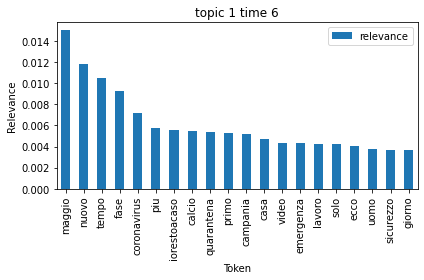

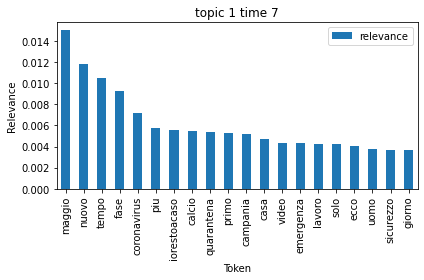

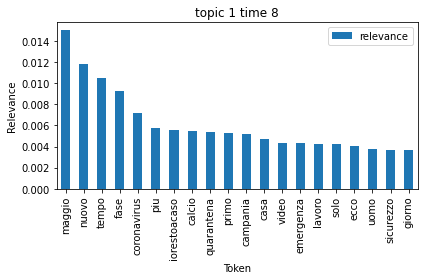

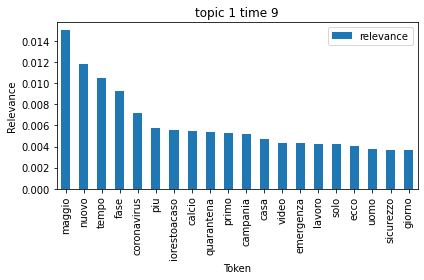

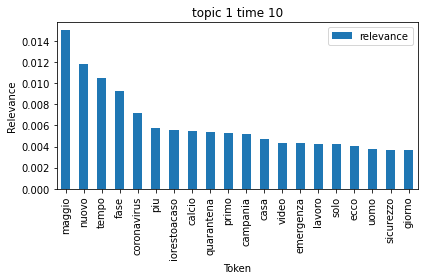

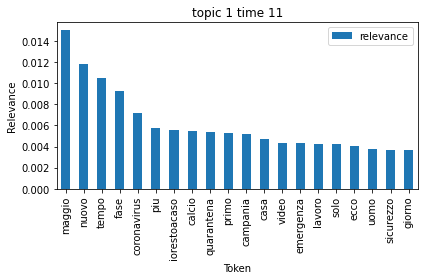

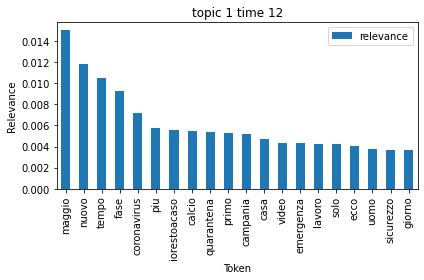

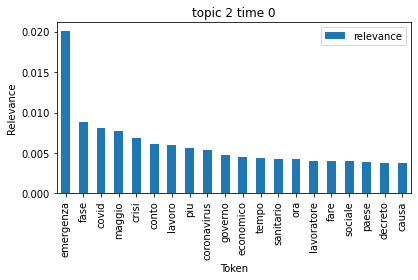

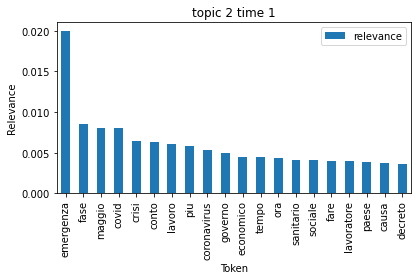

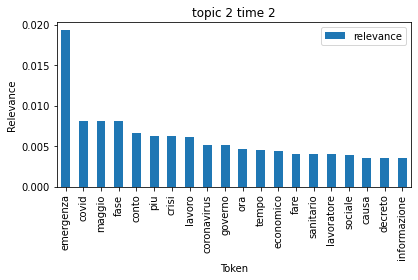

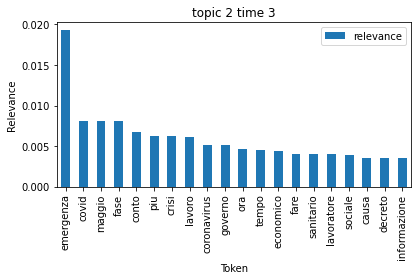

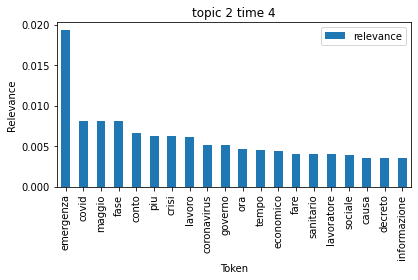

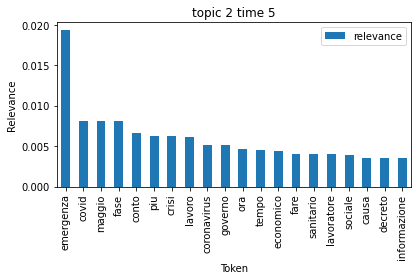

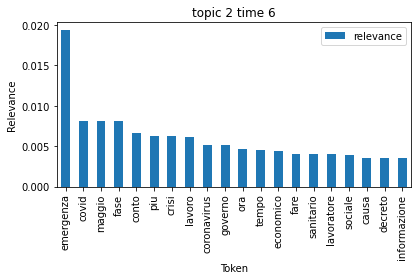

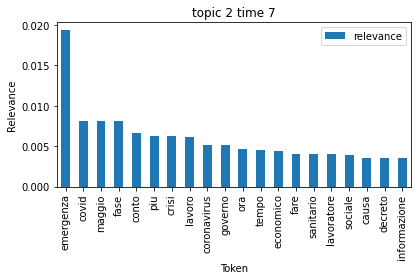

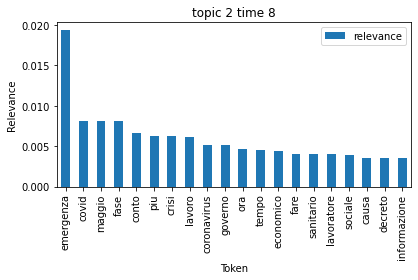

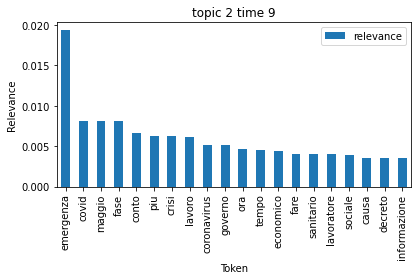

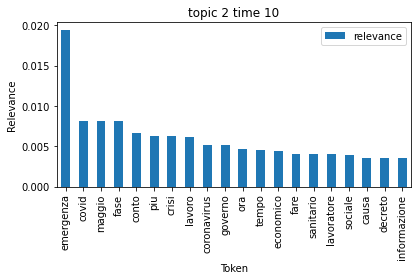

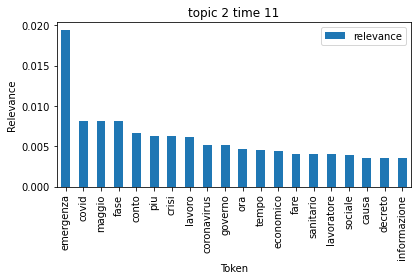

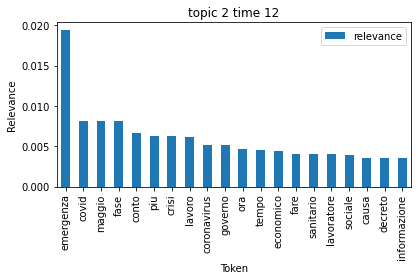

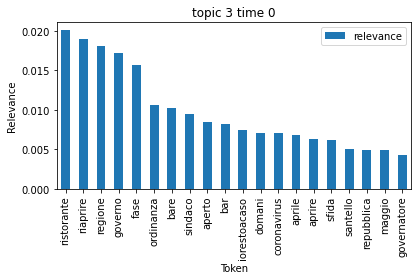

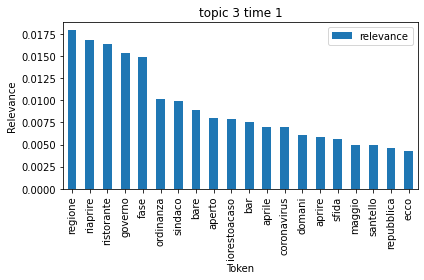

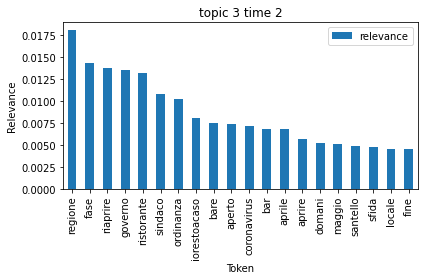

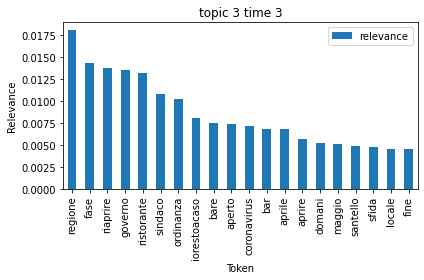

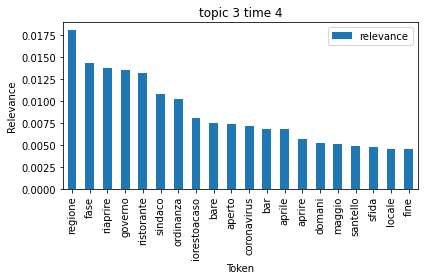

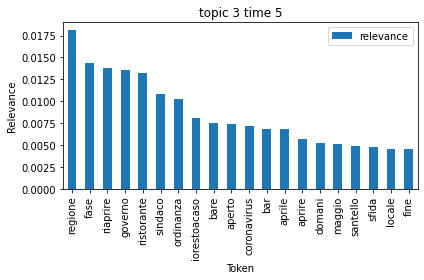

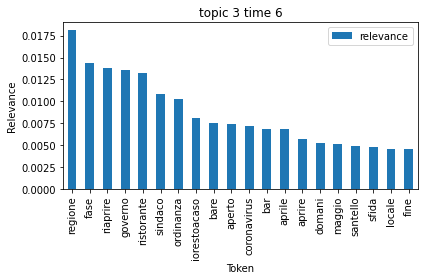

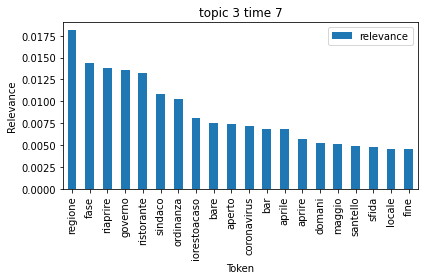

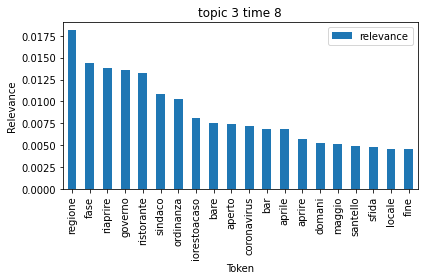

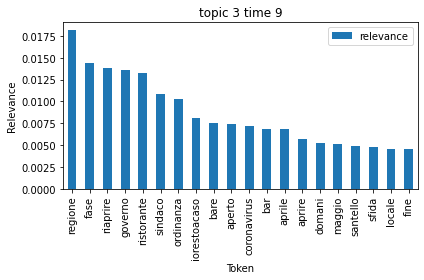

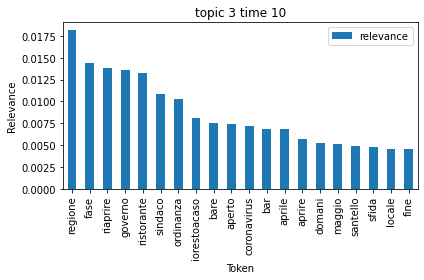

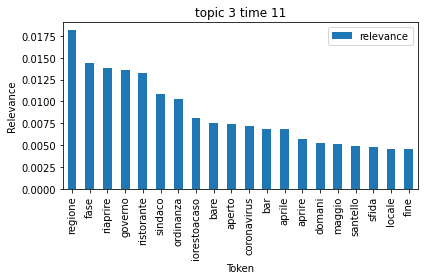

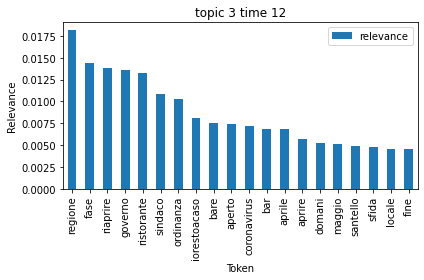

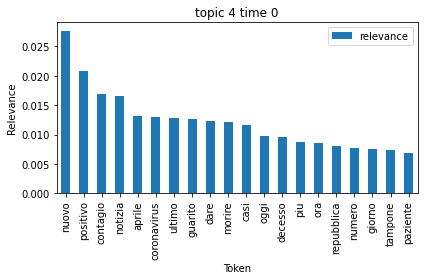

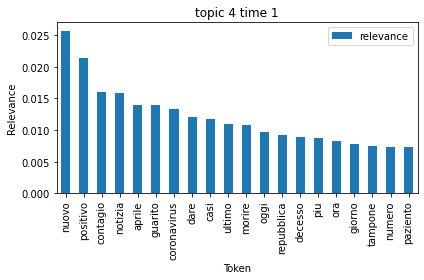

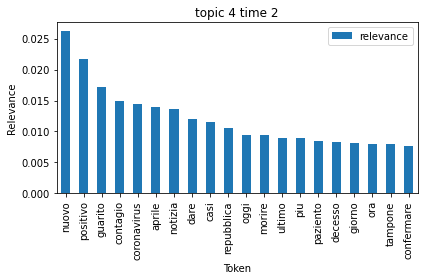

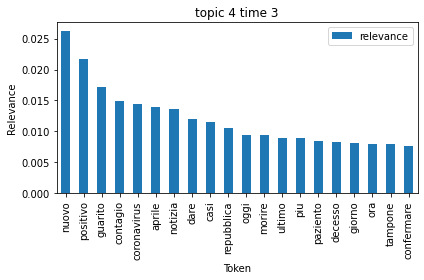

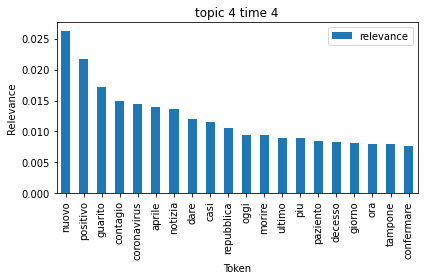

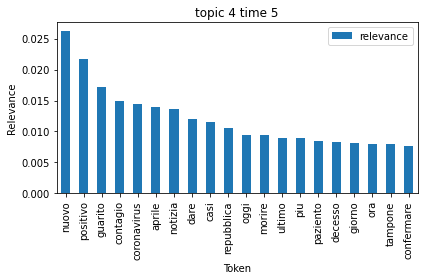

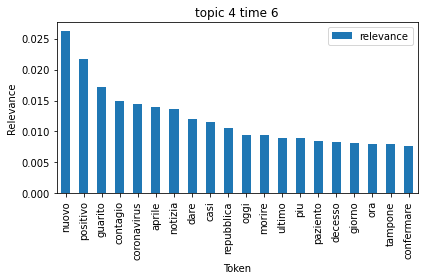

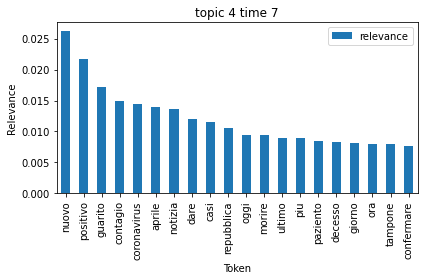

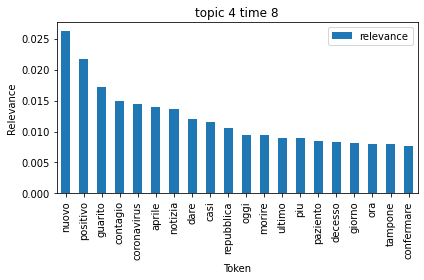

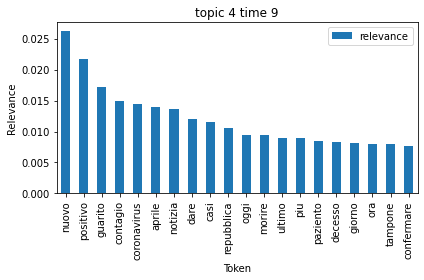

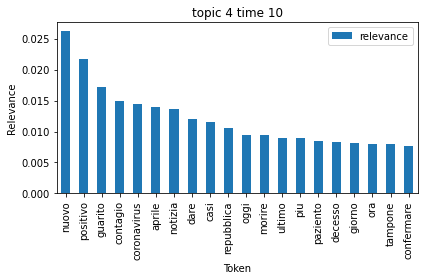

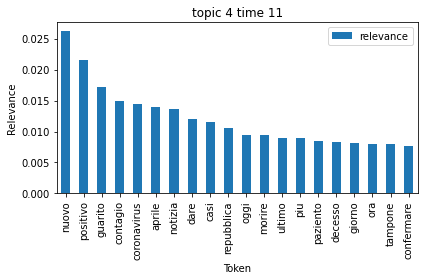

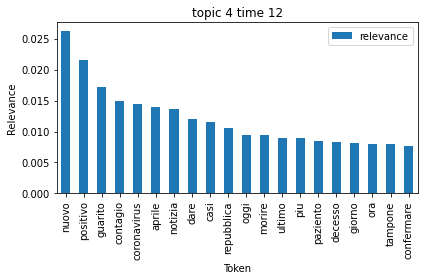

In [ ]:

result = pd.read_csv("<result.csv>")
# topic0 = result.loc[result['topic'] ==0] # seleziona tutti i topic 0 across times
# time11 = result.loc[result['time'] ==1] # seleziona tutti i topic del time =0 
# time11_topic1 = time11.loc[time11['topic'] ==0]
# time11_topic1.plot(kind='bar',x='token',y='relevance')
groups = result.groupby(['topic', 'time'])
for g in groups:
    # plt.figure()
    g[1].plot(kind='bar',x='token',y='relevance')
    plt.title(f'topic {g[0][0]} time {g[0][1]}')
    plt.xlabel('Token')
    plt.ylabel('Relevance')
    plt.tight_layout()
    filename = f'topic_{g[0][0]}_time_{g[0][1]}.jpg'
    save_path = f'<path>{filename}'
    plt.savefig(save_path)
    # plt.close()

In [ ]:
ldaseq.print_topics()

[[('emergenza', 0.013103714940563607),
  ('covid', 0.00984357705749925),
  ('tempo', 0.007948164207141138),
  ('crisi', 0.007835916330817656),
  ('iorestoacaso', 0.006227383356672325),
  ('piu', 0.005772508036447621),
  ('maggio', 0.00467353735161054),
  ('intervista', 0.004562791661628894),
  ('anno', 0.004391633139792278),
  ('causa', 0.004331793134543629),
  ('famiglia', 0.004123346295471492),
  ('bambino', 0.003847923471859384),
  ('nuovo', 0.003509419357942663),
  ('qui', 0.0034539349452432774),
  ('articolo', 0.0033642459160647857),
  ('venire', 0.0033462504833095185),
  ('piano', 0.003160143699182619),
  ('controllo', 0.0030471844335175496),
  ('informazione', 0.002940589281057852),
  ('diritto', 0.0028782815346599325)],
 [('coronavirus', 0.013748252034077969),
  ('emergenza', 0.011853170828191662),
  ('repubblica', 0.010901814200749352),
  ('via', 0.01031426996290259),
  ('paziento', 0.009923729476561248),
  ('covid', 0.008004565430577029),
  ('confermare', 0.007991469472582925